<a href="https://colab.research.google.com/github/martinfinis/HelloCodeSchoolProject/blob/master/COVID_19_FINAL_V1_0_Martin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Control and environment settings

In [ ]:
# try to crop the lung area only
bool_crop = True

# scale each image indepently - set the darkest pixel to zero and the lightest pixel to 255
bool_scale = False

# Random seed used in the notebook
RAND_SEED = 42

# Train InceptionV3 from scratch or load existing model 
REBUILD_INCEPTIONV3 = False

# Path variables
source_dir = '/content/curated_data/curated_data/'
train_dir = str(source_dir + 'train/')
test_dir = str(source_dir + 'test/')
validation_dir = str(source_dir + 'validation/')

# Path used to store and restore trained models
target_path = '/content/drive/.shortcut-targets-by-id/1lp7vo6EG60jba1Gk_tuNpvDm7q5ZXlKX/Telecom_Specialization_ML3/Students/Peter_Christoph_Marko_Martin/program/'

#Imports

In [ ]:
!pip install scikit-plot

In [ ]:
# Import required packages
from google.colab import drive
from google.colab.patches import cv2_imshow

import pylab as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import time
import os
import shutil
import tensorflow as tf
import cv2 as cv2

from IPython import display
from datetime import datetime

import scikitplot as skplt

from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import joblib
import lightgbm as lgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, InputLayer, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.python.keras.callbacks import History


%matplotlib inline

# Helper Functions

In [ ]:
def load_imagelist_label(main_dir, sub_dirs, data_format='/*.png'):
  """
  helper function to create a img list and a label list from the data files
  takes use of the global variables classes_list and data_fromat
  """
  img_list = []
  label_list = []

  for case in sub_dirs:#in original version, just a hint -> dict_case_df.keys():#dict_case_lst can be delete after final run
    file_list = glob.glob(os.path.join(main_dir, case + data_format))
    
    for f in range(len(file_list)):  
      img = cv2.imread(file_list[f], cv2.IMREAD_GRAYSCALE)
      #img = cv2.resize(img, (224, 224))#uncommit for final version, done in other function 
      img_list.append(img)
      label_list.append(case)

  return np.array(img_list), np.array(label_list)

In [ ]:
# Find a filename of an image correctly predicted with highest confidence
def get_best_image_name(model, generator, class_string):
  """
  model: trained model
  generator: fitted generator
  class_string: one of generator.class_indices: {'CAP': 0, 'COVID': 1, 'NonCOVID': 2}
  Returns:
  - image_file_path of (one of) the image(s) in generator which was 
  correctly predicted as belonging to the given class - i.e. prediction for 
  given class is highest value.
  - softmax predictions for all classes for this image.
  """


  print(f"generator.directory: {generator.directory}")
  print(f"generator.class_indices: {generator.class_indices}")

  class_n = generator.class_indices[class_string]

  y_true = generator.classes

  # Predictions for data in generator
  y_predict_softmax = model.predict(generator)

  # Choose index of maximum
  y_predict_max = np.argmax(y_predict_softmax, axis=-1)

  # Filter where model correctly predicts class_n
  correct_pred_bool = np.logical_and(y_predict_max == class_n, y_true == class_n)
  # Set wrong predictions to Zero
  correct_preds_float = y_predict_softmax[:,class_n] * correct_pred_bool
  # Find index of maximum prediction
  index_of_max = np.argmax(correct_preds_float)

  predictions_at_max = y_predict_softmax[index_of_max]

  filename_at_max = generator.filenames[index_of_max]
  filepath = str(generator.directory + filename_at_max)

  print(f"True class of image: {y_true[index_of_max]}")
  print(f"Predicted class of image: {y_predict_max[index_of_max]}")

  return filepath, predictions_at_max


# Test code:

# Uncomment one line:
# filepath, predictions = get_best_image_name(best_model_cnn, test_generator, 'CAP')
# filepath, predictions = get_best_image_name(best_model_cnn, test_generator, 'COVID')
# filepath, predictions = get_best_image_name(best_model_cnn, test_generator, 'NonCOVID')

# print(filepath)
# print(predictions)

# img = plt.imread(filepath)
# plt.imshow(img, cmap='gray')


# Test code for loop over classes:

# for cl in test_generator.class_indices:
#   print(cl)
#   filepath, predictions = get_best_image_name(best_model_cnn, test_generator, cl)
#   print(filepath)
#   print(predictions)

#   img = plt.imread(filepath)
#   plt.xticks([])
#   plt.yticks([])
#   plt.imshow(img, cmap='gray')
#   plt.show()

In [ ]:
# Find a filename of an image wrongly predicted with highest confidence
def get_worst_image_name(model, generator, class_string):
  """
  model: trained model
  generator: fitted generator
  class_string: one of generator.class_indices: {'CAP': 0, 'COVID': 1, 'NonCOVID': 2}
  Returns:
  - image_file_path of (one of) the image(s) in generator which was 
  incorrectly predicted as NOT belonging to the given class with highest 
  confidence - i.e. prediction for given class is lowest value.
  - softmax predictions for all classes for this image.
  """


  print(f"generator.directory: {generator.directory}")
  print(f"generator.class_indices: {generator.class_indices}")

  class_n = generator.class_indices[class_string]

  y_true = generator.classes

  # Predictions for data in generator
  y_predict_softmax = model.predict(generator)

  # Choose index of maximum
  y_predict_max = np.argmax(y_predict_softmax, axis=-1)

  # Searching for images where model predicts class_n, but class_n not true
  filter_bool = np.logical_and(y_predict_max == class_n, y_true != class_n)

  # Filter out the other predictions (set to Zero)
  wrong_preds_float = y_predict_softmax[:,class_n] * filter_bool
  # Find index of maximum prediction
  index_of_max = np.argmax(wrong_preds_float)

  predictions_at_max = y_predict_softmax[index_of_max]
  filename_at_max = generator.filenames[index_of_max]
  filepath = str(generator.directory + filename_at_max)

  print(f"True class of image: {y_true[index_of_max]}")
  print(f"Predicted class of image: {y_predict_max[index_of_max]}")

  return filepath, predictions_at_max

# Test code:

# Uncomment one line:
# filepath, predictions = get_worst_image_name(best_model_cnn, test_generator, 'CAP')
# filepath, predictions = get_worst_image_name(best_model_cnn, test_generator, 'COVID')
# filepath, predictions = get_worst_image_name(best_model_cnn, test_generator, 'NonCOVID')

#print(filepath)
#print(predictions)

#img = plt.imread(filepath)
#plt.imshow(img, cmap='gray')


# Test code for loop over classes

# for cl in test_generator.class_indices:
#   print(cl)
#   filepath, predictions = get_worst_image_name(best_model_cnn, test_generator, cl)
#   print(filepath)
#   print(predictions)

#   img = plt.imread(filepath)
#   plt.xticks([])
#   plt.yticks([])
#   plt.imshow(img, cmap='gray')
#   plt.show()


In [ ]:
# Plot the training history of a neural network
def plot_training_history(history: History):
    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    axs[0].plot(history.history['accuracy'], color='blue', label='train')
    axs[0].plot(history.history['val_accuracy'], color='orange', label='validation')
    axs[0].legend()
    axs[0].set_title('Classification Accuracy')
  
    axs[1].plot(history.history['loss'], color='blue', label='train')
    axs[1].plot(history.history['val_loss'], color='orange', label='validation')
    axs[1].legend()
    axs[1].set_title('Classification Loss')
    plt.show()

In [ ]:
# Save best model on Google Drive

def save_model_in_drive(model, model_name):

  # Initialize target path
  #target_path = '/content/drive/.shortcut-targets-by-id/1lp7vo6EG60jba1Gk_tuNpvDm7q5ZXlKX/Telecom_Specialization_ML3/Students/Peter_Christoph_Marko_Martin/program/'

  # Get Timestamp
  dateTimeObj = datetime.now()
  str_timestamp = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")

  # Create model filename
  model_filename = str(model_name + "_" + str_timestamp)
  # Create complete filepath
  model_filepath = str(target_path + model_filename)

  # Save model
  model.save(model_filepath)
  print(f"Model saved: {model_filepath}")

  return

# Test code
# save_model_in_drive(best_model_cnn, "best_model_cnn")

In [ ]:
def plot_confusion_matrix_x(labels,predictions,classes_name):
  """
  example:
  predictions=max_predict # np.argmax(y_predict, axis=-1)
  labels=test_generator.classes
  classes_name = artist_list
  """

  normalize = False

  # con_mat = tf.math.confusion_matrix(labels=labels, predictions=np.argmax(predictions, axis=-1) ).numpy()
  con_mat = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  if normalize == True:
    con_mat_df = pd.DataFrame(con_mat_norm,index = classes_name,columns = classes_name)
  else:
    con_mat_df = pd.DataFrame(con_mat,index = classes_name,columns = classes_name)


  figure = plt.figure(figsize=(4, 4))
  sns.heatmap(con_mat_df, annot=True,fmt='g',cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()




# Loading data

In [ ]:
# mount google drive to access dataset food
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# unzip the data on the virtual machine
%cd /content/

!unzip '/content/drive/.shortcut-targets-by-id/1lp7vo6EG60jba1Gk_tuNpvDm7q5ZXlKX/Telecom_Specialization_ML3/Students/Peter_Christoph_Marko_Martin/data/archive.zip'

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: curated_data/curated_data/2COVID/P024_121.png  
  inflating: curated_data/curated_data/2COVID/P024_122.png  
  inflating: curated_data/curated_data/2COVID/P024_123.png  
  inflating: curated_data/curated_data/2COVID/P024_124.png  
  inflating: curated_data/curated_data/2COVID/P024_125.png  
  inflating: curated_data/curated_data/2COVID/P024_127.png  
  inflating: curated_data/curated_data/2COVID/P024_128.png  
  inflating: curated_data/curated_data/2COVID/P024_129.png  
  inflating: curated_data/curated_data/2COVID/P024_130.png  
  inflating: curated_data/curated_data/2COVID/P024_131.png  
  inflating: curated_data/curated_data/2COVID/P024_132.png  
  inflating: curated_data/curated_data/2COVID/P024_133.png  
  inflating: curated_data/curated_data/2COVID/P024_134.png  
  inflating: curated_data/curated_data/2COVID/P024_135.png  
  inflating: curated_data/curated_data/2COVID/P024_136.png  
  inflating: curat

In [ ]:
##### Inconsistency between file names and file names in meta data #####
## ==> rename files to the names used in meta_data_covid.csv
!mv "/content/curated_data/curated_data/2COVID/17_Zhao_Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%0.png" "/content/curated_data/curated_data/2COVID/17_Zhao_Recurrence-of-COVID-19-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%0.png"

!mv "/content/curated_data/curated_data/2COVID/17_Zhao_Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png" "/content/curated_data/curated_data/2COVID/17_Zhao_Recurrence-of-COVID-19-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png"

In [ ]:
# Load data as dataframes
df_meta_cap = pd.read_csv('meta_data_cap.csv')
df_meta_covid = pd.read_csv('meta_data_covid.csv', encoding = "ISO-8859-1")
df_meta_normal = pd.read_csv('meta_data_normal.csv')

# Split data into training, valdiation and test data

In [ ]:
np.random.seed(RAND_SEED)

# Configuration of sizes
test_size = 0.1
validation_size = 0.1

# List of classes
classes_list = [('1NonCOVID','NonCOVID'), 
                ('2COVID','COVID'), 
                ('3CAP','CAP')]

In [ ]:
# Get patient to image mappings

# Covid patients
covid_patient_to_image = df_meta_covid.groupby(['Patient ID'])['File name'].apply(list).reset_index()
# Normal patients
normal_patient_to_image = df_meta_normal.groupby(['Patient ID'])['File name'].apply(list).reset_index()
# CAP patients
cap_patient_to_image = df_meta_cap.groupby(['Patient ID'])['File name'].apply(list).reset_index()

In [ ]:
def split_ids(patient_to_image, val_size, test_size):
  '''
  '''
  np.random.seed(RAND_SEED)
  # Calculate the number of training, valdiation and test samples
  len_all = len(patient_to_image)
  nb_test = np.floor(len_all * test_size).astype('int')
  nb_val = np.floor(len_all * val_size).astype('int')
  nb_train = len_all - (nb_test + nb_val).astype('int')
  # Create sub-samples of patient_to_image
  patient_ids = patient_to_image.index.values
  train_ids = np.random.choice(patient_ids, nb_train, replace=False)
  val_ids = np.random.choice(list(set(patient_ids)-set(train_ids)), nb_val, 
                             replace=False)
  test_ids = np.random.choice(list(set(patient_ids)-set(train_ids)-set(val_ids)),
                              nb_test, replace = False)
  
  return train_ids, val_ids, test_ids

In [ ]:
# Split data into training, validation and test subsets

sample_id_dict = {}

for _, cl_dest in classes_list:
  if cl_dest == 'COVID':
    # Split covid patients
    covid_train_ids, covid_val_ids, covid_test_ids = \
      split_ids(covid_patient_to_image, validation_size, test_size)
    
    # Add data to dictionary
    sample_id_dict[cl_dest] = {'IMG':covid_patient_to_image,
                               'TRAIN':covid_train_ids,
                               'VAL':covid_val_ids,
                               'TEST':covid_test_ids}
  elif cl_dest == 'NonCOVID':
    # Split normal patients
    norm_train_ids, norm_val_ids, norm_test_ids = \
      split_ids(normal_patient_to_image, validation_size, test_size)
    # Add data to dictionary
    sample_id_dict[cl_dest] = {'IMG':normal_patient_to_image,
                               'TRAIN':norm_train_ids,
                               'VAL':norm_val_ids,
                               'TEST':norm_test_ids}
  else: # CAP
    # Split cap patients
    cap_train_ids, cap_val_ids, cap_test_ids = \
      split_ids(cap_patient_to_image, validation_size, test_size)
    # Add data to dictionary
    sample_id_dict[cl_dest] = {'IMG':cap_patient_to_image,
                               'TRAIN':cap_train_ids,
                               'VAL':cap_val_ids,
                               'TEST':cap_test_ids}

In [ ]:
# Create new directories for training, validation and test data
!mkdir $train_dir
!mkdir $test_dir
!mkdir $validation_dir

# Create subdirectories for each class
for _, cl in classes_list:
  c_train = str(train_dir + cl)
  !mkdir $c_train
  c_test = str(test_dir + cl)
  !mkdir $c_test
  c_validation = str(validation_dir + cl)
  !mkdir $c_validation

In [ ]:
def move_files(patient_to_image, patient_ids, from_dir, to_dir):
  '''
  '''
  # Set a limit to mv-strings
  MAX_LEN = 20000

  # Check if at least one patient id was provided
  if len(patient_to_image) < 1:
    print('No files to move!')
    return None

  fs_to_move_batch = []  # move files batch-wise to improve processing time
  fs_to_move = ''
  for id in patient_ids:
    file_names = f' {from_dir}'.join([fn for fn in patient_to_image.at[id,'File name']])
    # Extend fs_to_move by new file names and from_dir at the beginning
    fs_to_move = fs_to_move + f' {from_dir}' + file_names
    if len(fs_to_move) > MAX_LEN:
      fs_to_move_batch.append(fs_to_move)
      fs_to_move = ''
  if len(fs_to_move) > 0:
    # Append the last fs_to_move string to the file_stack
    fs_to_move_batch.append(fs_to_move)
  for fs_to_move in fs_to_move_batch:
    !mv $fs_to_move $to_dir 


In [ ]:
# Move all data to new destinations
%%time

for cl_src, cl_dest in classes_list:
  from_dir = source_dir + cl_src + '/'
  
  imgs = sample_id_dict[cl_dest]['IMG']

  # Move training data
  to_dir = train_dir + cl_dest
  ids = sample_id_dict[cl_dest]['TRAIN']
  move_files(imgs, ids, from_dir, to_dir)

  # Move validation data
  to_dir = validation_dir + cl_dest
  ids = sample_id_dict[cl_dest]['VAL']
  move_files(imgs, ids, from_dir, to_dir)

  # Move test data
  to_dir = test_dir + cl_dest
  ids = sample_id_dict[cl_dest]['TEST']
  move_files(imgs, ids, from_dir, to_dir)
  

CPU times: user 217 ms, sys: 436 ms, total: 653 ms
Wall time: 6.56 s


# Models using non-preprocessed images

## Transfer learning based on InceptionV3

### Data perparation

In [ ]:
# Set target size of pictures to 224 x 224 as expected by the 
# pre-trained model 
target_size = (224, 224)

# Set batch size
batch_size = 64
    
# Create training ImageDataGenerator with data augmentation   
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range = (0.7, 1.3),
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range=45)

# ImageDataGenerators for valdidation and test only rescale images, i.e.
# pixel values are in [0.0, 1.0]
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Read data all data from directory
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=True,
        seed=RAND_SEED)

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False,
        seed=RAND_SEED)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False,
        seed=RAND_SEED)

Found 13602 images belonging to 3 classes.
Found 1997 images belonging to 3 classes.
Found 1505 images belonging to 3 classes.


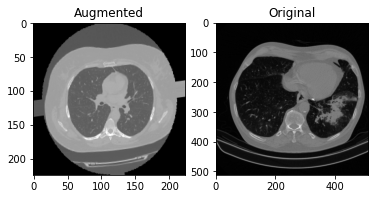

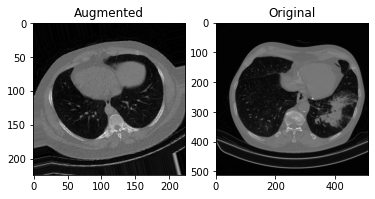

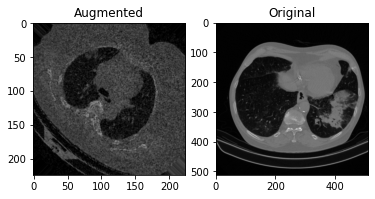

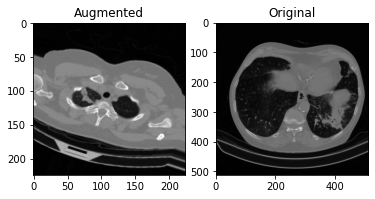

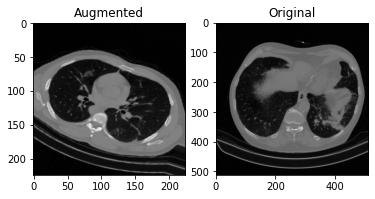

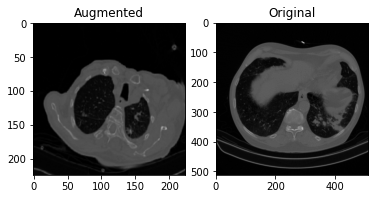

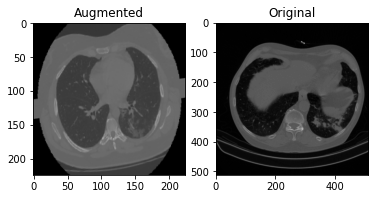

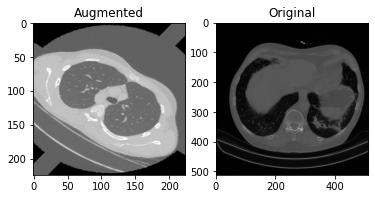

In [ ]:
# Visualize some augmented training images

data_batch = train_generator.next()
imgs = data_batch[0]
labels = data_batch[1]

# List of original file names
original_file_names = train_generator.filenames

nb_images = min(8, batch_size)

for i in range(nb_images):
    img = imgs[i]
    orig_img = plt.imread(str(train_dir + original_file_names[i]))
    f, ax = plt.subplots(1,2)
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Augmented')
    ax[1].imshow(orig_img, cmap='gray')
    ax[1].set_title('Original')
    plt.show()

### Model creation

In [ ]:
# Load model InceptionV3 without the top-classifier; weights are
# initialised to "imagenet"

np.random.seed(RAND_SEED)

inception = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)
#inception.summary()

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# Freeze all the weights in the convolutional layers
inception.trainable = False

In [ ]:
# Create the classifier on top of the convolutional layers

# Get the output of the last layer of the convolutional "network"
last_output = inception.layers[-1].output 

# Flatten the output to a vector
x = Flatten()(last_output)

# Hidden dense layer with 2048 neurons and relu activation function
x = Dense(2048, activation='relu')(x)
# Dropout layer with drop probability of 0.2
x = Dropout(0.2)(x)
# Output dense layer with three neurons, one for each class
x = Dense(3, activation='softmax')(x)

# Create the finale model
inception = Model(inputs=inception.input, outputs=x)
inception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Compile the model using Adam as optimizer
 
learning_rate = 0.0001
metrics = ['accuracy']
optimizer = Adam(learning_rate=learning_rate)

inception.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=metrics) 

In [ ]:
# Create a model checkpoint to store the best model based on the 
# valuation accuracy
mcp_inception = ModelCheckpoint('best_inception_model', 
                                monitor='val_accuracy', 
                                save_best_only=True, 
                                save_weights_only=False, 
                                verbose=1)

In [ ]:
# ----
if REBUILD_INCEPTIONV3:  # fit the model to training data
  nb_epochs = 20  # number of epochs to train the model
  history_inception = inception.fit(train_generator,
                                    epochs=nb_epochs,
                                    validation_data=validation_generator,
                                    verbose=1,
                                    callbacks=[mcp_inception],
                                    workers=8)
  # Load best model found during training
  best_inception = load_model('best_inception_model')
  # Store the model for later usage
  save_model_in_drive(best_inception, "best_inception_model")
else: # reload existing model
  best_inception = load_model(target_path + 'best_inception_model_29_Apr_2021_16_56_36')

### Model evaluation

In [ ]:
# Evaluate the best model against the testing data
best_inception.evaluate(test_generator)

24/24 [==============================] - 23s 247ms/step - loss: 0.5139 - accuracy: 0.8179


[0.5139446258544922, 0.8179401755332947]

In [ ]:
# If the model was build from data plot validation accuracy and loss at each
# epoch
if REBUILD_INCEPTIONV3:
  plot_training_history(history_inception)

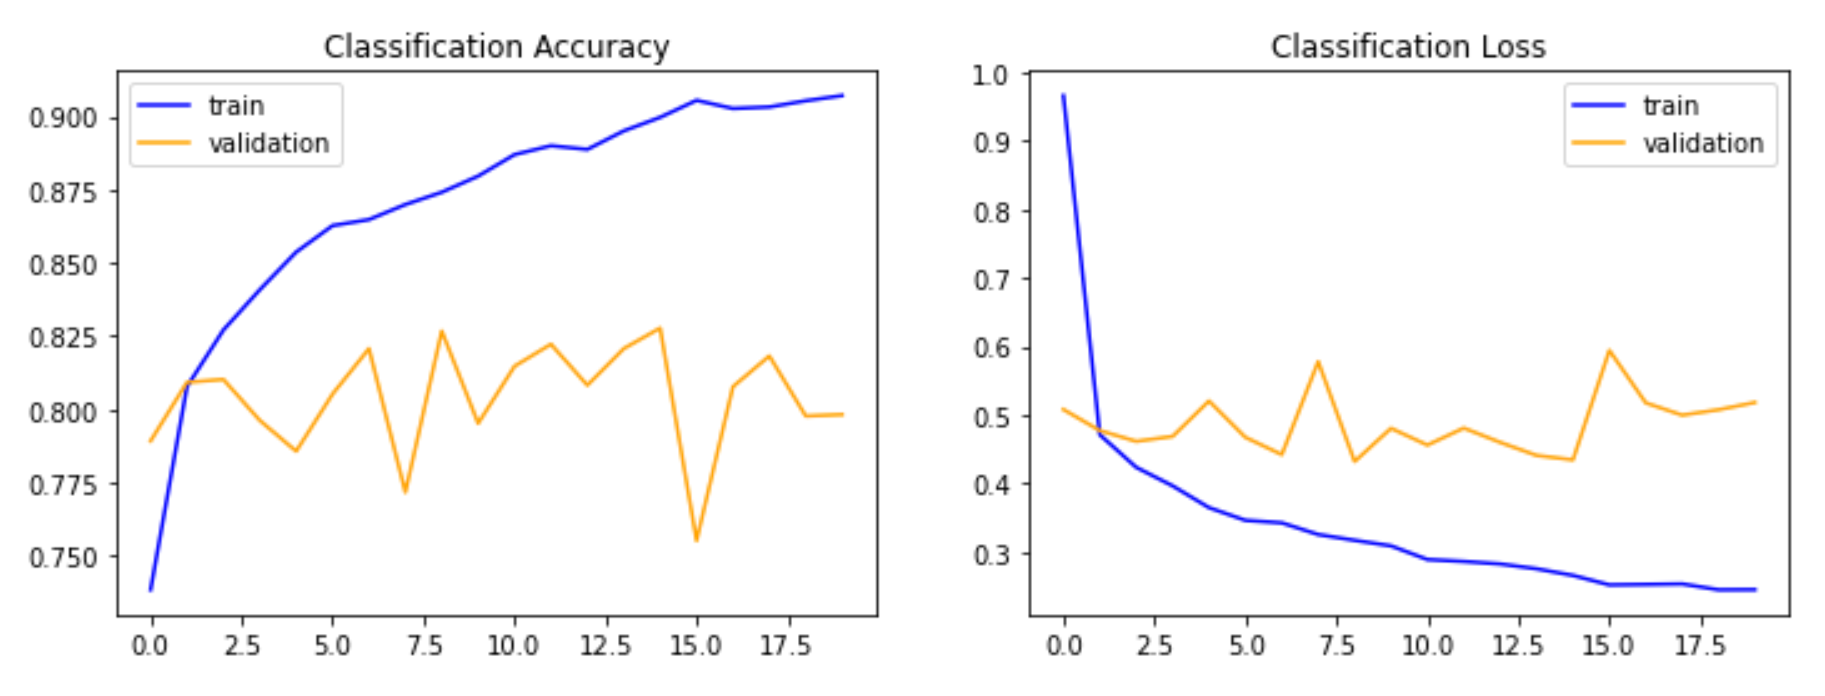

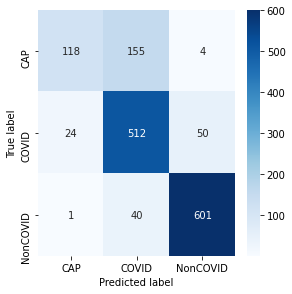

In [ ]:
# Plot the confusion matrix

# Get ground truth labels
y_true = test_generator.classes

# Get the labels predicted by the model
y_pred_proba = best_inception.predict(test_generator)
y_predict = np.argmax(y_pred_proba, axis=-1)
# Plot the confusion matrix
plot_confusion_matrix_x(labels=y_true,
                        predictions=y_predict,
                        classes_name=['CAP', 'COVID', 'NonCOVID'])

CAP
generator.directory: /content/curated_data/curated_data/test/
generator.class_indices: {'CAP': 0, 'COVID': 1, 'NonCOVID': 2}
True class of image: 1
Predicted class of image: 0
/content/curated_data/curated_data/test/COVID/P029_8.png
[9.5582348e-01 4.4176523e-02 2.2954463e-09]


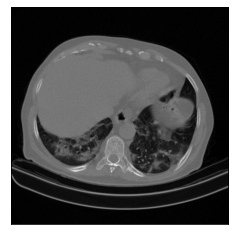

COVID
generator.directory: /content/curated_data/curated_data/test/
generator.class_indices: {'CAP': 0, 'COVID': 1, 'NonCOVID': 2}
True class of image: 0
Predicted class of image: 1
/content/curated_data/curated_data/test/CAP/cp026_95.png
[8.3788829e-05 9.9990463e-01 1.1547237e-05]


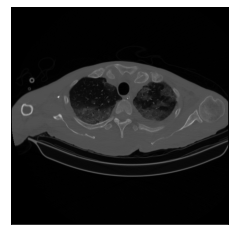

NonCOVID
generator.directory: /content/curated_data/curated_data/test/
generator.class_indices: {'CAP': 0, 'COVID': 1, 'NonCOVID': 2}
True class of image: 1
Predicted class of image: 2
/content/curated_data/curated_data/test/COVID/16_Morozov_study_0255_29.png
[4.0685723e-06 2.2969281e-02 9.7702664e-01]


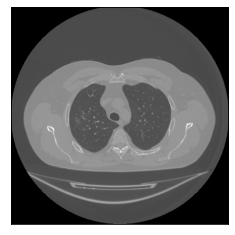

In [ ]:
# Get worst classified image of each class
for cl in test_generator.class_indices:   
  print(cl)
  filepath, predictions = get_worst_image_name(best_inception, test_generator, cl)
  print(filepath)
  print(predictions)

  img = plt.imread(filepath)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap='gray')
  plt.show()

CAP
generator.directory: /content/curated_data/curated_data/test/
generator.class_indices: {'CAP': 0, 'COVID': 1, 'NonCOVID': 2}
True class of image: 0
Predicted class of image: 0
/content/curated_data/curated_data/test/CAP/cap015_9.png
[9.993610e-01 2.986766e-04 3.403075e-04]


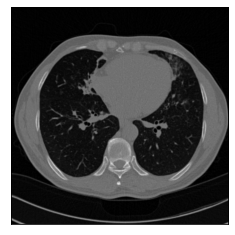

COVID
generator.directory: /content/curated_data/curated_data/test/
generator.class_indices: {'CAP': 0, 'COVID': 1, 'NonCOVID': 2}
True class of image: 1
Predicted class of image: 1
/content/curated_data/curated_data/test/COVID/17_Zhao_2020.03.20.20037325-p23-121.png
[3.4713000e-07 9.9999917e-01 4.2797433e-07]


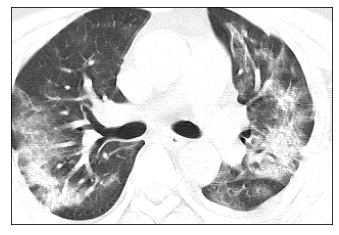

NonCOVID
generator.directory: /content/curated_data/curated_data/test/
generator.class_indices: {'CAP': 0, 'COVID': 1, 'NonCOVID': 2}
True class of image: 2
Predicted class of image: 2
/content/curated_data/curated_data/test/NonCOVID/16_Morozov_study_0208_22.png
[3.2883394e-09 1.4565858e-03 9.9854338e-01]


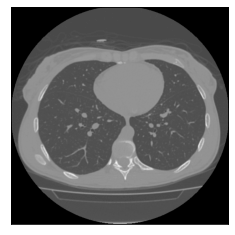

In [ ]:
# Get best classified image of each class
for cl in test_generator.class_indices:
  print(cl)
  filepath, predictions = get_best_image_name(best_inception, test_generator, cl)
  print(filepath)
  print(predictions)

  img = plt.imread(filepath)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap='gray')
  plt.show()

In [ ]:
# Get classification report
print(classification_report(test_generator.classes, 
                            y_predict, 
                            target_names=['CAP','COVID','NonCOVID']))

              precision    recall  f1-score   support

         CAP       0.83      0.43      0.56       277
       COVID       0.72      0.87      0.79       586
    NonCOVID       0.92      0.94      0.93       642

    accuracy                           0.82      1505
   macro avg       0.82      0.75      0.76      1505
weighted avg       0.83      0.82      0.81      1505



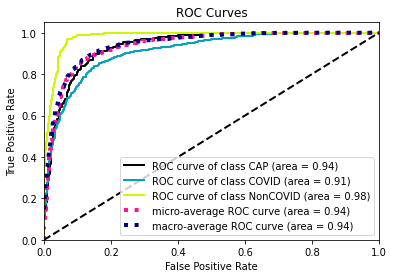

In [ ]:
# Display the ROC curve for each class
y_true_label = y_true.astype('str')
y_true_label[y_true_label == '0'] = 'CAP'
y_true_label[y_true_label == '1'] = 'COVID'
y_true_label[y_true_label == '2'] = 'NonCOVID'
y_probas = best_inception.predict(test_generator)
skplt.metrics.plot_roc(y_true_label, y_pred_proba)
plt.show()

# Preprocessing

## Function

In [ ]:
def crop_image_to_biggest_contour(in_img, in_threshold_lower, in_threshold_upper, in_display_transformation):
  # create a binary thresholded image
  _, binary = cv2.threshold(in_img, in_threshold_lower, in_threshold_upper, cv2.THRESH_BINARY)#_INV)

  # # find the contours from the thresholded image
  contours, hierarchy = cv2.findContours(binary.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  
  # https://stackoverflow.com/questions/48526973/how-do-i-find-ten-biggest-contours
  # or something like this
  contours = sorted(contours, key=cv2.contourArea)[-1:]

  # draw all contours
  contour_image = cv2.drawContours(in_img.copy(), contours, -1, (0, 0, 255), 2)

  # https://stackoverflow.com/questions/37912928/fill-the-outside-of-contours-opencv
  # paint all pixels outside black
  #stencil = np.zeros(in_img.shape).astype(in_img.dtype)
  #color = [255, 255, 255]
  #cv2.fillPoly(stencil, contours, color)
  #fill = cv2.bitwise_and(in_img, stencil)

  # # der hintergrund innerhalb der lunge wird dunkler ... warum?
  # ## mask = np.zeros(in_img.shape, np.uint8)
  # mask = in_img * 0
  # tmp = cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
  # #tmp = cv2.drawContours(cv2.bitwise_not(mask), contours, -1, (255), thickness=cv2.FILLED)
  # fill = cv2.bitwise_and(in_img, mask)

  # to_dark = fill[np.min(contours[0][:, :, 1]) : np.max(contours[0][:, :, 1]), np.min(contours[0][:, :, 0]) : np.max(contours[0][:, :, 0])]

  # https://stackoverflow.com/questions/15589517/how-to-crop-an-image-in-opencv-using-python
  # crop the image
  if len(contours) > 0:
    final = in_img[np.min(contours[0][:, :, 1]) : np.max(contours[0][:, :, 1]), np.min(contours[0][:, :, 0]) : np.max(contours[0][:, :, 0])]
  else:
    final = in_img

  if in_display_transformation:
    fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(12, 8))
    axs[0].imshow(in_img, cmap="gray")
    axs[0].get_xaxis().set_visible(False)
    axs[0].get_yaxis().set_visible(False)
    axs[1].imshow(binary, cmap="gray")
    axs[1].get_xaxis().set_visible(False)
    axs[1].get_yaxis().set_visible(False)
    axs[2].imshow(contour_image, cmap="gray")
    axs[2].get_xaxis().set_visible(False)
    axs[2].get_yaxis().set_visible(False)
    axs[3].imshow(final, cmap="gray")
    axs[3].get_xaxis().set_visible(False)
    axs[3].get_yaxis().set_visible(False)
    plt.show()

  return final

## Image preprocessing

In [ ]:
# provide the data set directories as list
dirs = [train_dir, test_dir, validation_dir]

# flags for manual inspection of the cropping function
bool_display_transformation = False
bool_debug = False
# minimum size (in percentage) of the cropped image 
float_image_min = 0.3

# filter to only respect png image files
data_format = '/*.png'
counter_no_contour_found = 0

# for all data set directories ...
for dir in dirs:
  # for all class directories ...
  for _, cl in classes_list:
    # get the files in the specific directory ...
    file_list = glob.glob(os.path.join(dir, cl + data_format))
    
    # for each file in the specific directory ...
    for f in range(len(file_list)):
      # load the file using opencv
      img = cv2.imread(file_list[f], cv2.IMREAD_GRAYSCALE)

      # set the initial lower lightness threshold
      int_lower_threshold = 100
      # flag to control the run to avoid to get to small subareas of the image
      bool_run = True

      # cropping
      while (bool_run and bool_crop):
        # call the cropping function
        img_result = crop_image_to_biggest_contour(img, int_lower_threshold, 255, bool_display_transformation)

        # check if the returned image is at least as big as defined 
        if (cv2.countNonZero(img_result) > (img.size * float_image_min)):
          # if yes, no further cropping necessary
          bool_run = False
          # replace the origin image with the cropped image
          img = img_result
        # if the cropped image is smaller as defined, decrease the lower threshold for contour detection
        elif int_lower_threshold > 10:
          int_lower_threshold = int_lower_threshold - 10
        # if the threshold cannot be reduced further stop further cropping tries
        else:
          counter_no_contour_found += 1
          bool_run = False

        # for manual inspection of the cropping function
        if bool_display_transformation and bool_debug:
          %sx read -p 'input'
        # for manual inspection of the cropping function
        elif bool_display_transformation:
          time.sleep(1.0)

        # for manual inspection of the cropping function
        if bool_display_transformation:
          time.sleep(3.0) 
      
      # if the flag for scaling is set ...
      if bool_scale:
        # identify the smallest value in the image and reduce all pixel with this value - smallest pixel will become 0
        img = img - np.min(img)
        # identify the largest pixel in the image, scale all pixel in the range [0, 1] and expand the range to [0, 255]
        img = (img / np.max(img)) * 255

      # resize all images and save the changes
      img = cv2.resize(img, (224, 224))
      cv2.imwrite(file_list[f], img)

# Models using pre-cropped images

## Logistic regression

In [ ]:
X_train, y_train = load_imagelist_label(train_dir, [x[1] for x in classes_list])
X_train = X_train / 255.0

In [ ]:
X_val, y_val = load_imagelist_label(validation_dir, [x[1] for x in classes_list])
X_val = X_val / 255.0

In [ ]:
X_test, y_test = load_imagelist_label(test_dir, [x[1] for x in classes_list])
X_test = X_test / 255.0

In [ ]:
clf_final = LogisticRegression(penalty='none', tol=0.2, solver='saga', multi_class='multinomial')

In [ ]:
clf_final.fit(X_train.reshape(X_train.shape[0], -1), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='none',
                   random_state=None, solver='saga', tol=0.2, verbose=0,
                   warm_start=False)

In [ ]:
clf_final.score(X_train.reshape(X_train.shape[0], -1), y_train)

0.7861343920011763

In [ ]:
log_loss(y_train, clf_final.predict_proba(X_train.reshape(X_train.shape[0], -1)))

0.5751588799556089

<Figure size 288x288 with 0 Axes>

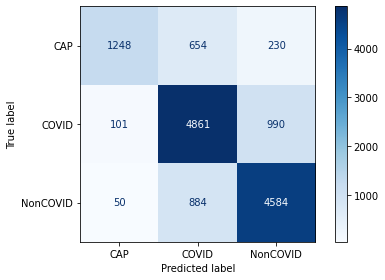

In [ ]:
figure = plt.figure(figsize=(4, 4))
plot_confusion_matrix(clf_final, X_train.reshape(X_train.shape[0], -1), y_train, cmap=plt.cm.Blues, values_format = '.0f')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(classification_report(y_train, clf_final.predict(X_train.reshape(X_train.shape[0], -1)), target_names=clf_final.classes_))

              precision    recall  f1-score   support

         CAP       0.89      0.59      0.71      2132
       COVID       0.76      0.82      0.79      5952
    NonCOVID       0.79      0.83      0.81      5518

    accuracy                           0.79     13602
   macro avg       0.81      0.74      0.77     13602
weighted avg       0.79      0.79      0.78     13602



In [ ]:
clf_final.score(X_val.reshape(X_val.shape[0], -1), y_val)

0.6990485728592889

In [ ]:
log_loss(y_val, clf_final.predict_proba(X_val.reshape(X_val.shape[0], -1)))

0.7017669376083504

<Figure size 288x288 with 0 Axes>

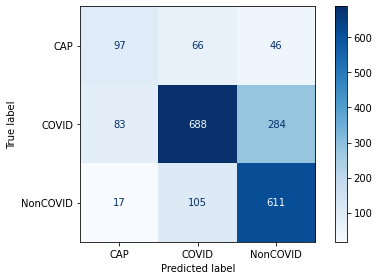

In [ ]:
figure = plt.figure(figsize=(4, 4))
plot_confusion_matrix(clf_final, X_val.reshape(X_val.shape[0], -1), y_val, cmap=plt.cm.Blues, values_format = '.0f')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(classification_report(y_val, clf_final.predict(X_val.reshape(X_val.shape[0], -1)), target_names=clf_final.classes_))

              precision    recall  f1-score   support

         CAP       0.49      0.46      0.48       209
       COVID       0.80      0.65      0.72      1055
    NonCOVID       0.65      0.83      0.73       733

    accuracy                           0.70      1997
   macro avg       0.65      0.65      0.64      1997
weighted avg       0.71      0.70      0.70      1997



In [ ]:
clf_final.score(X_test.reshape(X_test.shape[0], -1), y_test)

0.6903654485049834

In [ ]:
log_loss(y_test, clf_final.predict_proba(X_test.reshape(X_test.shape[0], -1)))

0.7575253696781068

<Figure size 288x288 with 0 Axes>

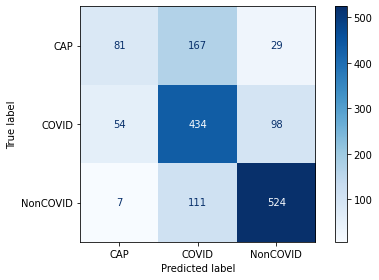

In [ ]:
figure = plt.figure(figsize=(4, 4))
plot_confusion_matrix(clf_final, X_test.reshape(X_test.shape[0], -1), y_test, cmap=plt.cm.Blues, values_format = '.0f')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(classification_report(y_test, clf_final.predict(X_test.reshape(X_test.shape[0], -1)), target_names=clf_final.classes_))

              precision    recall  f1-score   support

         CAP       0.57      0.29      0.39       277
       COVID       0.61      0.74      0.67       586
    NonCOVID       0.80      0.82      0.81       642

    accuracy                           0.69      1505
   macro avg       0.66      0.62      0.62      1505
weighted avg       0.69      0.69      0.68      1505



## LightGBM

In [ ]:
#the final saveed model was trained without cropping, therefore this model run's only one uncropped images
load_path = ''
if bool_crop:
  load_path = '/content/drive/.shortcut-targets-by-id/1lp7vo6EG60jba1Gk_tuNpvDm7q5ZXlKX/Telecom_Specialization_ML3/Students/Peter_Christoph_Marko_Martin/program/best_model_lgbm/crop_lgb.pkl_29_Apr_2021_16_05_18'
else:
  load_path = '/content/drive/.shortcut-targets-by-id/1lp7vo6EG60jba1Gk_tuNpvDm7q5ZXlKX/Telecom_Specialization_ML3/Students/Peter_Christoph_Marko_Martin/program/best_model_lgbm/lgb.pkl_29_Apr_2021_14_36_53'

lgbm_final = joblib.load(load_path)

#if train True override loaded model and train again
train = False

if train:
  params = {'max_depth': 5,
            'num_leaves': 10, 
            'n_estimators': 100}

  lgbm_final = lgb.LGBMClassifier(**params,random_state=42)
  lgbm_final.fit(X_train.reshape(X_train.shape[0], -1), y_train)



### train

In [ ]:
log_loss(y_train, lgbm_final.predict_proba(X_train.reshape(X_train.shape[0], -1)))

0.20353582059484251

In [ ]:
y_pred = lgbm_final.predict(X_train.reshape(X_train.shape[0], -1))

In [ ]:
accuracy_score(y_train, y_pred)

0.9543449492721658

<Figure size 288x288 with 0 Axes>

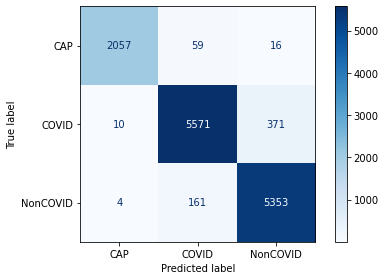

In [ ]:
figure = plt.figure(figsize=(4, 4))
plot_confusion_matrix(lgbm_final, X_train.reshape(X_train.shape[0], -1), y_train, cmap=plt.cm.Blues, values_format = '.0f')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(classification_report(y_train, lgbm_final.predict(X_train.reshape(X_train.shape[0], -1)), target_names=lgbm_final.classes_))

              precision    recall  f1-score   support

         CAP       0.99      0.96      0.98      2132
       COVID       0.96      0.94      0.95      5952
    NonCOVID       0.93      0.97      0.95      5518

    accuracy                           0.95     13602
   macro avg       0.96      0.96      0.96     13602
weighted avg       0.95      0.95      0.95     13602



### validate

In [ ]:
log_loss(y_val, lgbm_final.predict_proba(X_val.reshape(X_val.shape[0], -1)))

0.5207174486938304

In [ ]:
y_pred = lgbm_final.predict(X_val.reshape(X_val.shape[0], -1))

In [ ]:
accuracy_score(y_val, y_pred)

0.786179268903355

<Figure size 288x288 with 0 Axes>

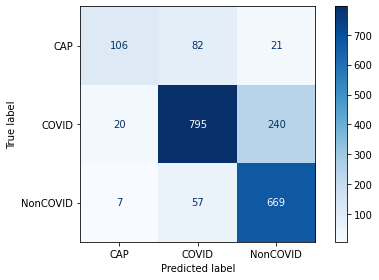

In [ ]:
figure = plt.figure(figsize=(4, 4))
plot_confusion_matrix(lgbm_final, X_val.reshape(X_val.shape[0], -1), y_val, cmap=plt.cm.Blues, values_format = '.0f')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(classification_report(y_val, lgbm_final.predict(X_val.reshape(X_val.shape[0], -1)), target_names=lgbm_final.classes_))

              precision    recall  f1-score   support

         CAP       0.80      0.51      0.62       209
       COVID       0.85      0.75      0.80      1055
    NonCOVID       0.72      0.91      0.80       733

    accuracy                           0.79      1997
   macro avg       0.79      0.72      0.74      1997
weighted avg       0.80      0.79      0.78      1997



### test

In [ ]:
log_loss(y_test, lgbm_final.predict_proba(X_test.reshape(X_test.shape[0], -1)))

0.5085068645740496

In [ ]:
y_pred = lgbm_final.predict(X_test.reshape(X_test.shape[0], -1))

In [ ]:
accuracy_score(y_test, y_pred)

0.7960132890365449

<Figure size 288x288 with 0 Axes>

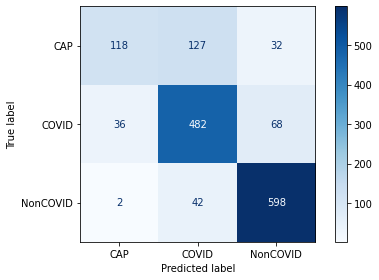

In [ ]:
figure = plt.figure(figsize=(4, 4))
plot_confusion_matrix(lgbm_final, X_test.reshape(X_test.shape[0], -1), y_test, cmap=plt.cm.Blues, values_format = '.0f')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(classification_report(y_test, lgbm_final.predict(X_test.reshape(X_test.shape[0], -1)), target_names=lgbm_final.classes_))

              precision    recall  f1-score   support

         CAP       0.76      0.43      0.55       277
       COVID       0.74      0.82      0.78       586
    NonCOVID       0.86      0.93      0.89       642

    accuracy                           0.80      1505
   macro avg       0.78      0.73      0.74      1505
weighted avg       0.79      0.80      0.78      1505

